In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
sys.path.insert(0, '../')
from scipy import misc
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers import LocallyConnected2D
from keras.layers.convolutional import Conv2D
from keras.layers import *
from keras import Model
from keras import optimizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,TensorBoard, Callback
import matplotlib.pyplot as plt
%matplotlib nbagg
from keras.utils import np_utils
from keras import backend as K
import cv2
from common import util
from sklearn.model_selection import train_test_split
import random
import glob
import tensorflow as tf
K.set_image_dim_ordering('th')

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/dlutils/plot_image_batch_w_labels.py:16: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
   

In [2]:
np.max(misc.imread("/media/drc/DATA/chris_labelfusion/RGBDCNNTest/15predicted_depth.png"))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


249

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


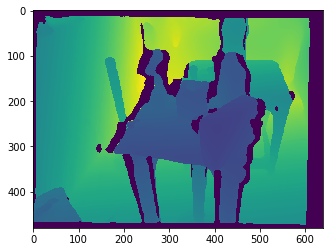

In [4]:
plt.figure()
plt.imshow(misc.imread("/media/drc/DATA/chris_labelfusion/RGBDCNNTest/15predicted_depth.png"))

<IPython.core.display.Javascript object>


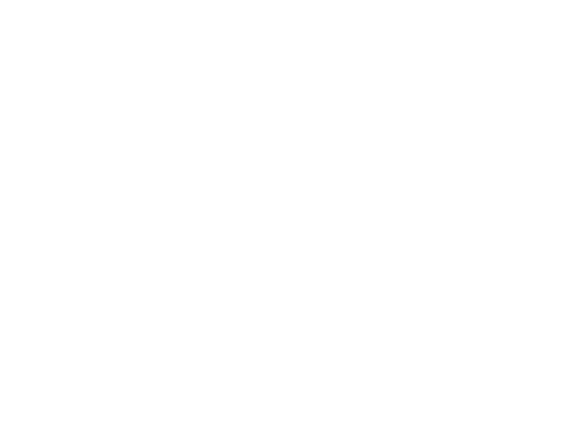

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


In [258]:
path = "/media/drc/DATA/chris_labelfusion/CORL2017/logs_test/2017-06-16-47/resized_images/"
stuff = os.listdir(path)
plt.figure()
plt.imshow(misc.imread(path+stuff[np.random.randint(len(stuff))]))

In [48]:
import noise
from scipy.misc import toimage


In [49]:
def sigmoid(x):
    return 1. / (1 + np.exp(-10*x))

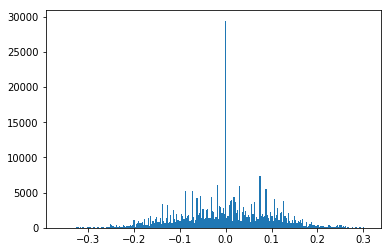

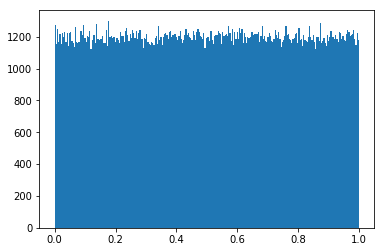

In [53]:

p = perlin_map(scale=8.0,octaves = 7,base= np.random.randint(1000),lacunarity = 6.0)
r = np.random.random((480,640))
plt.figure()
plt.hist(p.ravel(), bins=256)
plt.show()
plt.figure()
plt.hist(r.ravel(), bins=256)
plt.show()

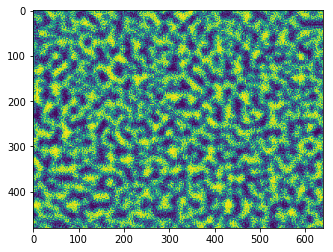

In [61]:
%matplotlib inline
plt.figure()
plt.imshow(img)

<IPython.core.display.Javascript object>


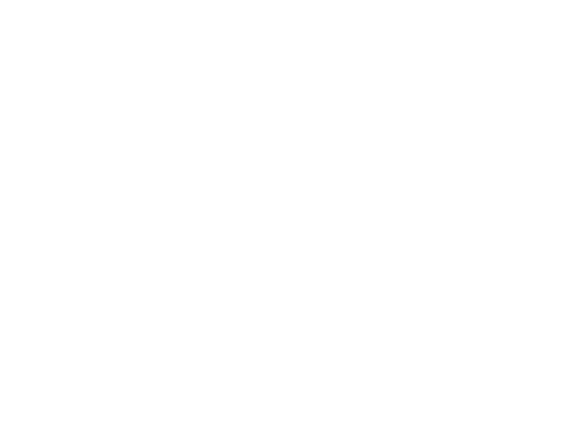

In [60]:
img = sigmoid(perlin_map(scale=20.0,octaves = 7,base= np.random.randint(1000),lacunarity = 6.0))
plt.figure()
plt.imshow(img)

<IPython.core.display.Javascript object>


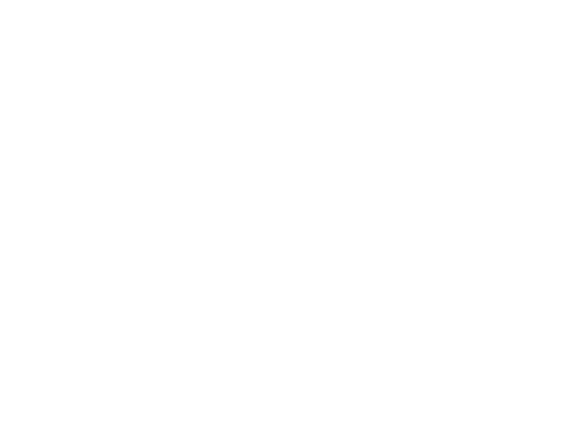

<IPython.core.display.Javascript object>


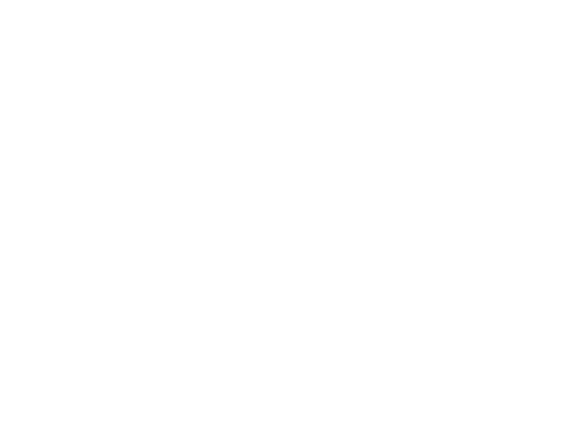

In [57]:
%matplotlib nbagg
plt.figure()
plt.imshow(sigmoid(perlin_map(scale=10.0,octaves = 7,base= np.random.randint(1000),lacunarity = 6.0)))
plt.figure()
plt.imshow(np.random.random((480,640)))

In [52]:
def perlin_map(shape = (480,640),scale = 100.0,octaves = 6,persistence = 0.5,lacunarity = 2.0,base = 0):
    img = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            img[i][j] = noise.pnoise2(i/scale, 
                                       j/scale, 
                                       octaves=octaves, 
                                       persistence=persistence, 
                                       lacunarity=lacunarity, 
                                       repeatx=shape[1], 
                                       repeaty=shape[0], 
                                       base=base)
    return img

In [2]:
def ratio_from_normal(img):
    return img[:,:,2]

def convert_rgb_normal(img):
    return (img/255.*2)-1.

In [3]:
def hot_vectorize(x,value = 0):
    zero_mask = x==value
    non_zero_mask = x!=value
    x[zero_mask] = 1
    x[non_zero_mask] = 0
    return x.astype(float)

def stack_frames(frames,img_height,img_width,channels):
    stack  = np.zeros((1,img_height,img_width,channels))
    index = 0
    for i in frames:
        num_chan = 1 if len(np.shape(i)) ==2 else np.shape(i)[2]
        stack[0,:,:,index:index+num_chan] = np.reshape(i,(img_height,img_width,num_chan))
        index += num_chan
    return stack

def grab_frame(files,i,path,func=None):
    img = misc.imread(path+files[i])
    if func:
        return func(img)
    return img

def grab_frame1(path,func=None):
    img = misc.imread(path)
    if func:
        return func(img)
    return img

def normalize(x):
    return x.astype(float)/3500.

def normalize_depth(x):
    return x.astype(float)/3000.

def convert_rgb_normal(img):
    return (img/255.*2)-1

def bounding_box(img,size = 100):
    h,w = np.shape(img)
    non_zeros = np.nonzero(img)
    x_min = np.min(non_zeros[0])
    x_max = np.max(non_zeros[0])
    y_min = np.min(non_zeros[1])
    y_max = np.max(non_zeros[1])
    out = (x_min,x_min+size,y_min,y_min+size) if size else (x_min,x_max,y_min,y_max)#minuce or plus coordinates
    if x_min< 0 or x_min+size > h or y_min<0 or y_min+size>w:
        return None
    return out

def crop(x,x1 = 100,x2 = 500,y1 = 50, y2 = 450):
    x = x[y1:y2,x1:x2]
    return x
def flip_vert(x,y):
    y= np.flip(y,axis=0)
    x= np.flip(x,axis=0)
    return x,y
def flip_hor(x,y):
    x= np.flip(x,axis=1)
    y= np.flip(y,axis=1)
    return x,y
def rotate(x,y):
    degrees = np.random.randint(360)
    centerx = tuple(np.array(x.shape[1::-1]) / 2)
    centery = tuple(np.array(y.shape[1::-1]) / 2)
    rotx = cv2.getRotationMatrix2D(centerx, degrees, 1.0)
    roty = cv2.getRotationMatrix2D(centery, degrees, 1.0)
    x = cv2.warpAffine(x, rotx, x.shape[1::-1], flags=cv2.INTER_LINEAR)
    y = cv2.warpAffine(y, roty, y.shape[1::-1], flags=cv2.INTER_LINEAR)
    return x,y
def augment(x,y,func = [],bias_to_real = .5):
    #x = crop(x)
   # y = crop(y)
    if np.random.rand()>bias_to_real:#bias to real images
        function = np.random.choice(func)
        x,y=function(x,y)
    return x,y


In [4]:
def cross_validate(samples,ways):
    samples = np.copy(samples)
    random.shuffle(samples)
    tests = np.array_split(samples,ways)
    return tests
def grab_test_train(tests,i):
    tests = np.copy(tests)
    test = list(tests).pop(i)
    train = np.concatenate(tests)
    return (train,test)
    

In [101]:
val = cross_validate(samples,10)
train, test = grab_test_train(val,0)

In [204]:
len(train), len(test)

(227737, 22774)

In [124]:
np.shape(samples)

(100, 3)

In [19]:
samples = gen_samples1("/media/drc/DATA/chris_labelfusion/RGBDCNN/")#directories=['2017-06-16-30']

227737


In [102]:
train = generate_data_custom_depth(samples,img_height=480,img_width=640)

In [18]:
def gen_samples1(directory,shuffle = True, directories=[]):
    samples = []
    dirs = os.listdir(directory) if len(directories)==0 else filter(lambda x: x in directories,os.listdir(directory))
    for i in dirs:
        path = os.path.join(directory, i)+"/"
        if os.access(path, os.R_OK):
            gt_normal = sorted(glob.glob(path+"*_normal_*"))
            gt_depth = sorted(glob.glob(path+"*_depth_*"))
            depth = sorted(glob.glob(path+"*_depth.png*"))
            samples.extend(zip(gt_depth,gt_normal,depth))
    if shuffle:
        random.shuffle(samples)
    print len(samples)
    return samples  

In [6]:
def gen_samples(directory,shuffle = True, directories=[]):
    samples = []
    dirs = os.listdir(directory) if len(directories)==0 else filter(lambda x: x in directories,os.listdir(directory))
    for i in dirs:
        path = os.path.join(directory, i)+"/"
        if os.access(path, os.R_OK):
            gt_depth = sorted(glob.glob(path+"*_truth.png"))
            depth = sorted(glob.glob(path+"*_depth.png"))
            samples.extend(zip(gt_depth,depth))
    if shuffle:
        random.shuffle(samples)
    return samples                

In [7]:
def generate_data_custom_both(samples,img_height=480,img_width=640,batch_size=4,func=[]):
    i = 0
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,2))#2
        stack2 = np.zeros((batch_size,img_height,img_width,1))
        j=0
        while j<batch_size:
            try: 
                rgb = samples[i][0]
                normal = samples[i][1]
                depth = samples[i][2]
                normal_img = grab_frame1(normal,convert_rgb_normal)[:,:,2]
                rgb_img = grab_frame1(rgb,normalize)
                depth_img = grab_frame1(depth,hot_vectorize)
                
                #rgb_img,depth_img = augment(rgb_img,depth_img,func,bias_to_real = .5)
                stack1[j,:,:,0] = rgb_img
                stack1[j,:,:,1] = normal_img
                stack2[j,:,:,0] = depth_img
                j+=1
                i= (i+1)%len(samples)
            except Exception:
                i=(i+1)%len(samples)
        yield (stack1,stack2)

In [8]:
def generate_data_custom_depth(samples,img_height=480,img_width=640,batch_size=4,func=[]):
    i = 0
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,1))
        stack2 = np.zeros((batch_size,img_height,img_width,1))
        j=0
        while j<batch_size:
            try: 
                rgb = samples[i][0]
                depth = samples[i][2]
                rgb_img = grab_frame1(rgb,normalize)
                depth_img = grab_frame1(depth,hot_vectorize)
                rgb_img,depth_img = augment(rgb_img,depth_img,func,bias_to_real = .5)
                stack1[j] = np.reshape(rgb_img,(img_height,img_width,1))
                stack2[j] = np.reshape(depth_img,(img_height,img_width,1))
                j+=1
                i= (i+1)%len(samples)
            except Exception:
                i=(i+1)%len(samples)
        yield (stack1,stack2)

In [9]:
def generate_data_custom1(depth_as_mask=True,img_height=480,img_width=640,batch_size=4,path="/media/drc/DATA/CNN/",dir_name = "test/",filter_files = None,func=None):

    rgb_path = path+"rgb/"
    depth_path = path+"depth/"

    rgb = np.sort(os.listdir(rgb_path))
    depth = np.sort(os.listdir(depth_path))

    if filter_files:
            rgb = np.sort(filter(lambda x: filter_files in x, rgb))
            depth = np.sort(filter(lambda x: filter_files in x, depth))

    i = -1
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,3))
        stack2 = np.zeros((batch_size,img_height,img_width,1))

        for j in range(batch_size):
            i= (i+1)%len(rgb)
            rgb_img = grab_frame(rgb,i,rgb_path,func)
          
            depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
            stack = stack_frames([rgb_img],img_height,img_width,3)
            stack1[j] = stack
            stack2[j] = np.reshape(depth_img,(img_height,img_width,1))
        yield (stack1,stack2)

In [174]:
def generate_data_custom3(depth_as_mask=True,img_height=480,img_width=640,batch_size=8,path="/media/drc/DATA/CNN/",dir_name = "test/",filter_files = None,func=None):

    rgb_path = path+"rgb/"+"rgb/"
    depth_path = path+"depth/"+ "depth/"
    gtdepth_path = path+"gtdepth/" + "gtdepth/"
    normal_path = path+"normal/" + "normal/"

    rgb = np.sort(os.listdir(rgb_path))
    normal = np.sort(os.listdir(normal_path))
    depth = np.sort(os.listdir(depth_path))
    gtdepth = np.sort(os.listdir(gtdepth_path))

    if filter_files:
            rgb = np.sort(filter(lambda x: filter_files in x, rgb))
            normal = np.sort(filter(lambda x: filter_files in x, normal))
            depth = np.sort(filter(lambda x: filter_files in x, depth))
            gtdepth = np.sort(filter(lambda x: filter_files in x, gtdepth))

    i = -1
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,7))
        stack2 = np.zeros((batch_size,img_height,img_width,1))

        for j in range(batch_size):
            i= (i+1)%len(depth)
            rgb_img = grab_frame(rgb,i,rgb_path,func)
            normal_img = grab_frame(normal,i,normal_path,normalize)
            gtdepth_img = grab_frame(gtdepth,i,gtdepth_path,normalize_depth)
            depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
            gtdepth_img[gtdepth_img==0]=1.

            stack = stack_frames([gtdepth_img,normal_img,rgb_img],img_height,img_width,7)
            stack1[j] = stack
            stack2[j] = np.reshape(depth_img,(img_height,img_width,1))
        yield (stack1,stack2)

In [14]:
def generate_data_custom(depth_as_mask=True,img_height=480,img_width=640,batch_size=8,channels =1,path="/media/drc/DATA/CNN/",dir_name = "test/",filter_files = None,func=None):

    rgb_path = path+"rgb/"+"rgb/"
    depth_path = path+"depth/"+ "depth/"
    gtdepth_path = path+"gtdepth/" + "gtdepth/"
    normal_path = path+"normal/" + "normal/"

    rgb = np.sort(os.listdir(rgb_path))
    normal = np.sort(os.listdir(normal_path))
    depth = np.sort(os.listdir(depth_path))
    gtdepth = np.sort(os.listdir(gtdepth_path))

    if filter_files:
            rgb = np.sort(filter(lambda x: filter_files in x, rgb))
            normal = np.sort(filter(lambda x: filter_files in x, normal))
            depth = np.sort(filter(lambda x: filter_files in x, depth))
            gtdepth = np.sort(filter(lambda x: filter_files in x, gtdepth))

    i = -1
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,channels))
        stack2 = np.zeros((batch_size,img_height,img_width,1))

        for j in range(batch_size):
            i= (i+1)%len(depth)
            rgb_img = grab_frame(rgb,i,rgb_path,func)
            normal_img = grab_frame(normal,i,normal_path,normalize)
            gtdepth_img = grab_frame(gtdepth,i,gtdepth_path,normalize_depth)
            depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
            a = bounding_box(gtdepth_img,img_height)
            while not a:
                i= (i+1)%len(depth)
                rgb_img = grab_frame(rgb,i,rgb_path,func)
                normal_img = grab_frame(normal,i,normal_path,normalize)
                gtdepth_img = grab_frame(gtdepth,i,gtdepth_path,normalize_depth)
                depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
                a = bounding_box(gtdepth_img,img_height)

            x1,x2,y1,y2 = a
            depth_img = depth_img[x1:x2,y1:y2] 
            gtdepth_img = gtdepth_img[x1:x2,y1:y2]
            normal_img = normal_img[x1:x2,y1:y2]
            gtdepth_img[gtdepth_img==0]=1.

            #stack = stack_frames([gtdepth_img,normal_img,rgb_img],img_height,img_width,4)
            stack = stack_frames([gtdepth_img],img_height,img_width,channels)

            stack1[j] = stack
            stack2[j] = np.reshape(depth_img,(img_height,img_width,1))
        yield (stack1,stack2)

In [68]:
gen  = generate_data_custom( func=normalize)

In [17]:
img_height=400
img_width=400

In [44]:
np.shape(train.next()[1])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


(4, 480, 640, 1)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


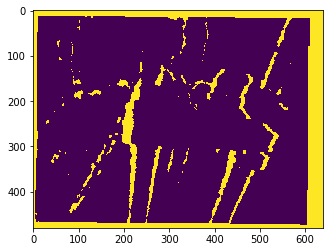

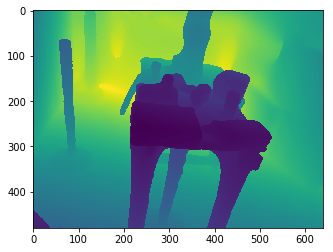

In [11]:
%matplotlib inline
now = train.next()
plt.figure()
plt.imshow(now[1][0,:,:,0])
plt.figure()
#plt.imshow(now[0][0][:,:,1])
#plt.figure()
plt.imshow(now[0][0][:,:,0])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


<IPython.core.display.Javascript object>


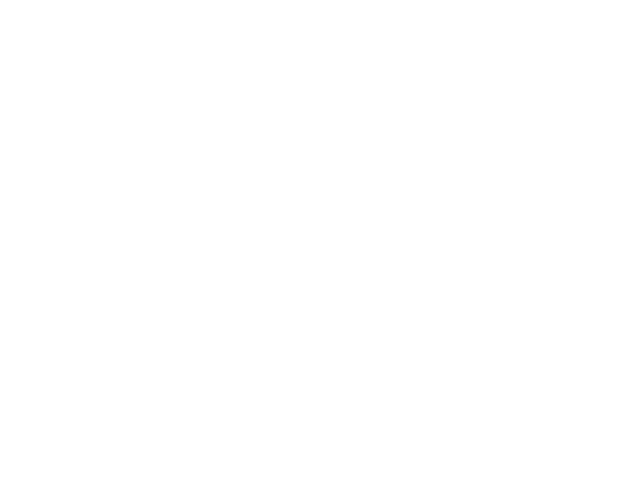

<IPython.core.display.Javascript object>


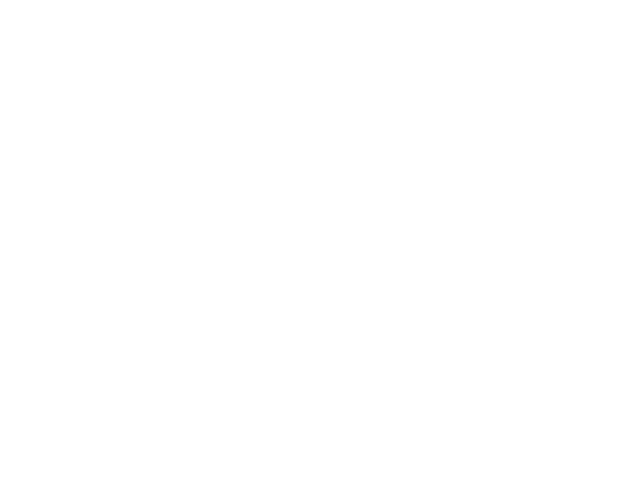

<IPython.core.display.Javascript object>


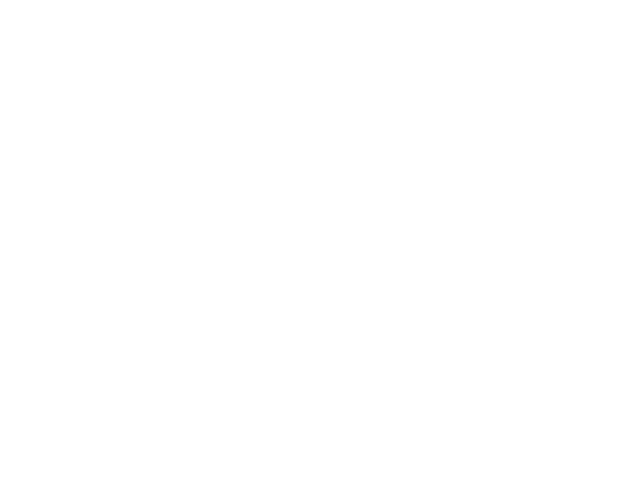

<IPython.core.display.Javascript object>


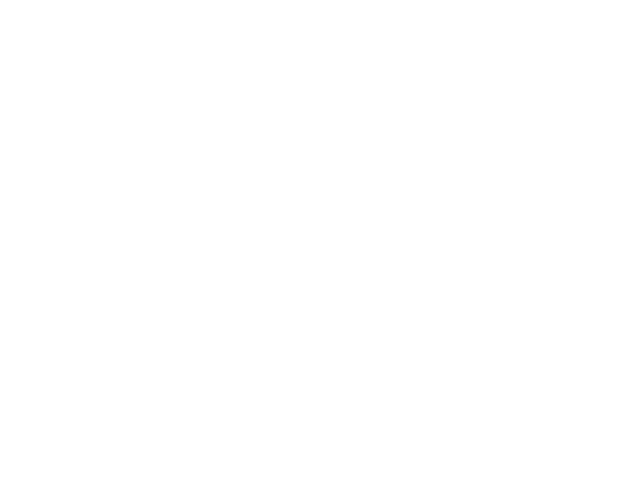

In [58]:
%matplotlib nbagg
now = gen.next()
plt.figure()
plt.imshow(np.reshape(now[1][0],(480,640)))
plt.figure()
plt.imshow(np.reshape(now[0][0,:,:,0],(480,640)))
plt.figure()
plt.imshow(np.reshape(now[0][0,:,:,1:4],(480,640,3)))
plt.figure()
plt.imshow(np.reshape(now[0][0,:,:,4:],(480,640,3)))

In [12]:
img_height = 480 #check with old params
img_width = 640
inputs = Input((img_height, img_width,1))

In [21]:
from keras import models
from keras.layers.core import Activation, Reshape, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
import json

img_w = img_width
img_h = img_height
n_labels = 2

kernel = 3

encoding_layers = [
    Convolution2D(16, kernel, border_mode='same', input_shape=( img_h, img_w,1),data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(16, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(data_format='channels_last'),

    Convolution2D(32, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(32, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(data_format='channels_last'),

    Convolution2D(64, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(64, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(64, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(data_format='channels_last'),

    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(data_format='channels_last'),

    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(128, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(data_format='channels_last'),
]

autoencoder = models.Sequential()
autoencoder.encoding_layers = encoding_layers

for l in autoencoder.encoding_layers:
    autoencoder.add(l)

decoding_layers = [
    UpSampling2D(data_format='channels_last'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(data_format='channels_last'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(64, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(data_format='channels_last'),
    Convolution2D(64, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(64, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(32, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(data_format='channels_last'),
    Convolution2D(32, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(16, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(data_format='channels_last'),
    Convolution2D(16, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(1, 1, border_mode='valid',data_format='channels_last'),
    BatchNormalization(),
]
autoencoder.decoding_layers = decoding_layers
for l in autoencoder.decoding_layers:
    autoencoder.add(l)


#autoencoder.add(Reshape((n_labels, img_h * img_w)))
#autoencoder.add(Permute((2, 1)))
autoencoder.add(Activation('sigmoid'))

autoencoder.summary()
autoencoder.compile(optimizer = optimizers.Adam(lr = 1e-4), loss =  binary_crossentropy, metrics = ['accuracy'])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, 3, padding="same", data_format="channels_last", input_shape=(480, 640,...)`
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, 3, padding="same", data_format="channels_last")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, 3, padding="same", data_format="channels_last")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, 3, padding="same", data_format="channels_last")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, 3, padding="same", data_format="channels_last")`
/usr/local/lib/python2.7/dist-packages/ipyker

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_79 (Conv2D)           (None, 480, 640, 16)      160       
_________________________________________________________________
batch_normalization_79 (Batc (None, 480, 640, 16)      64        
_________________________________________________________________
activation_79 (Activation)   (None, 480, 640, 16)      0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 480, 640, 16)      2320      
_________________________________________________________________
batch_normalization_80 (Batc (None, 480, 640, 16)      64        
_________________________________________________________________
activation_80 (Activation)   (None, 480, 640, 16)      0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 240, 320, 16)      0         
__________

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


<IPython.core.display.Javascript object>


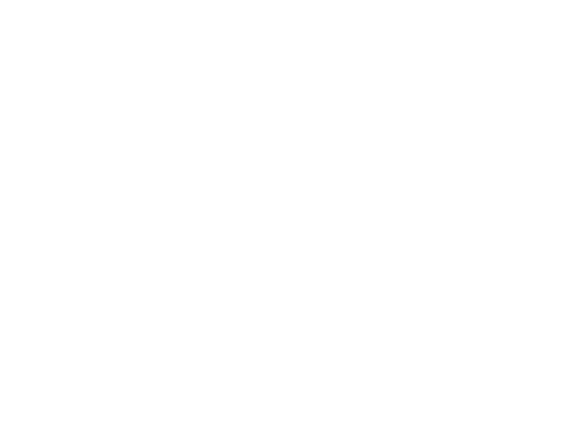

In [233]:
import struct
cpp_int_size = 4
cpp_ushort_size = 2
i = np.random.randint(1000)
with open("/media/drc/DATA/linemod/driller/data/depth"+str(i)+".dpt", 'rb') as f:
    rows_b = f.read(cpp_int_size) # I assume that the C++ int in question has 4 bits ... trial and error
    cols_b = f.read(cpp_int_size)

    R = struct.unpack('<i', rows_b)[0] # small endian
    C = struct.unpack('<i', cols_b)[0]
    depth_image_str = f.read(R * C * cpp_ushort_size)
depth_img = np.fromstring(depth_image_str, dtype=np.uint16).reshape([R, C])
plt.figure()
plt.imshow(depth_img)

In [234]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

img = depth_img
dst_TELEA = cv2.inpaint(img,(img==0).astype(np.uint8),3,cv2.INPAINT_TELEA)
dst_NS = cv2.inpaint(img,(img==0).astype(np.uint8),3,cv2.INPAINT_NS)

# plt.subplot(221), plt.imshow(img)
# plt.title('degraded image')
# plt.subplot(222), plt.imshow((img==0).astype(np.uint8), 'gray')
# plt.title('mask image')
# plt.subplot(223), plt.imshow(dst_TELEA)
# plt.title('TELEA')
# plt.subplot(224), plt.imshow(dst_NS)
# plt.title('NS')

# plt.tight_layout()
# plt.show()

<IPython.core.display.Javascript object>


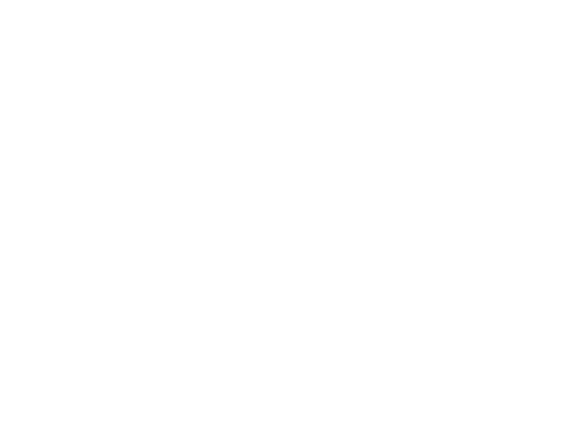

In [235]:
batch = np.zeros((1,480,640,1))
batch[0,:,:,0] = dst_TELEA/3500.
x = model.predict_on_batch(batch)
plt.figure()
plt.imshow(x[0,:,:,0])

In [237]:
apply_mask(x,dst_TELEA,.5)

<IPython.core.display.Javascript object>


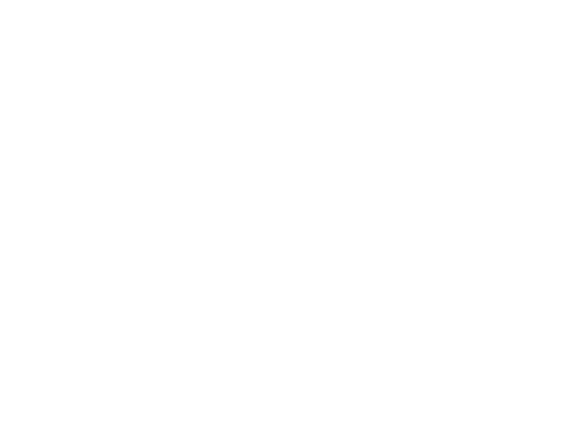

<IPython.core.display.Javascript object>


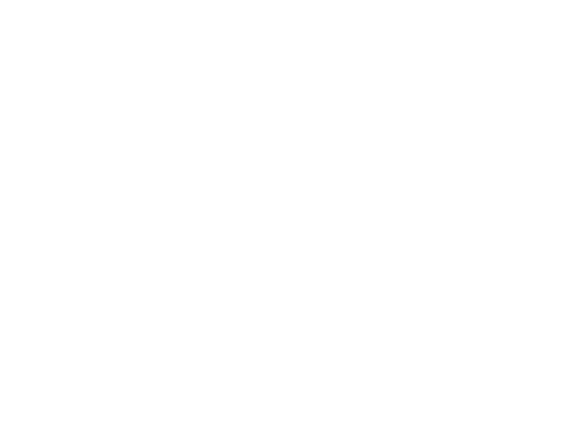

In [259]:
plt.figure()
plt.imshow(dst_TELEA)
plt.figure()
plt.imshow(depth_img)

In [193]:
def apply_mask(mask,depth,threshold):
    epsilon = .05
    h,w = np.shape(depth)
    mask = np.reshape(mask,(h,w))

    depth[mask>threshold]=0
    #img = np.random.random((480,640))
    img = sigmoid(perlin_map(scale=20.0,octaves = 7,base= np.random.randint(1000),lacunarity = 6.0))
    stochastic_mask = mask>=img
    #stochastic_mask = np.logical_and(np.logical_and((mask<=threshold), mask>epsilon), img<threshold)
    depth[stochastic_mask] = 0

In [11]:
import scipy

In [ ]:
scipy.misc.t

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


<IPython.core.display.Javascript object>


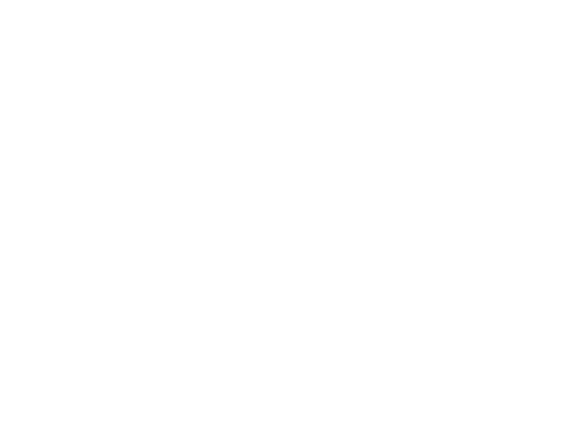

In [28]:
%matplotlib nbagg
plt.imshow(misc.imread("/media/drc/DATA/chris_labelfusion/RGBDCNNTest/0gtdepth.png"))

In [ ]:
def convert_to dropout(imgs,autoencoder,out="./"):
    

In [23]:
autoencoder.load_weights("../models/net_segnet_aug.hdf5")

In [15]:
def binary_crossentropy(y_true, y_pred):
    print np.shape(y_true),np.shape(y_pred)
    return K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [16]:
def weighted_pixelwise_crossentropy(class_weights):
    
    def loss(y_true, y_pred):
        epsilon = tf.convert_to_tensor(.01, y_pred.dtype.base_dtype)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        return - tf.reduce_sum(tf.multiply(y_true * tf.log(y_pred), tf.convert_to_tensor(class_weights.values())))

    return loss

In [11]:
_EPSILON = 10e-8
from tensorflow.python.ops import clip_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn

def crop1(x,x1 = 100,x2 = 500,y1 = 50, y2 = 450):
    x = x[:,y1:y2,x1:x2,:]
    return x

In [12]:
def binary_crossentropy(target, output, from_logits=False):
    """Binary crossentropy between an output tensor and a target tensor.
      Arguments:
          target: A tensor with the same shape as `output`.
          output: A tensor.
          from_logits: Whether `output` is expected to be a logits tensor.
              By default, we consider that `output`
              encodes a probability distribution.
      Returns:
          A tensor.
      """
    #target  = crop1(target)
   # output = crop1(output)
    #print np.shape(target), np.shape(output)

      # Note: nn.softmax_cross_entropy_with_logits
      # expects logits, Keras expects probabilities.
    if not from_logits:
        # transform back to logits
        epsilon_ =  tf.convert_to_tensor(_EPSILON, output.dtype.base_dtype)
        output = clip_ops.clip_by_value(output, epsilon_, 1 - epsilon_)
        output = math_ops.log(output / (1 - output))
    return nn.weighted_cross_entropy_with_logits(target, output, .15, name=None)


In [171]:
class_weight = {0 : .85,
    1: .15}

In [13]:
batch_size =4

In [160]:
model_checkpoint = ModelCheckpoint('net_segnet_aug_custom metric.hdf5', monitor='loss',verbose=1, save_best_only=True)
check2 = TensorBoard(log_dir='logs1', histogram_freq=0, batch_size=batch_size, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
print('Fitting model...')
autoencoder.fit_generator(train, nb_epoch=10000,steps_per_epoch=100, verbose=1, shuffle=True, callbacks=[model_checkpoint,check2])

Fitting model...


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., shuffle=True, verbose=1, steps_per_epoch=100, epochs=10000, callbacks=[<keras.ca...)`
  after removing the cwd from sys.path.


Epoch 1/10000


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


 99/100 [============================>.] - ETA: 0s - loss: 0.0248 - acc: 0.9606
Epoch 00001: loss improved from inf to 0.02474, saving model to net_segnet_aug_custom metric.hdf5
100/100 [==============================] - 46s 462ms/step - loss: 0.0247 - acc: 0.9607
Epoch 2/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0252 - acc: 0.9597
Epoch 00002: loss did not improve
100/100 [==============================] - 45s 449ms/step - loss: 0.0251 - acc: 0.9599
Epoch 3/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0253 - acc: 0.9588
Epoch 00003: loss did not improve
100/100 [==============================] - 47s 466ms/step - loss: 0.0253 - acc: 0.9589
Epoch 4/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0256 - acc: 0.9581
Epoch 00004: loss did not improve
100/100 [==============================] - 46s 458ms/step - loss: 0.0256 - acc: 0.9580
Epoch 5/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0254 - acc: 0.9

Epoch 38/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0244 - acc: 0.9598
Epoch 00038: loss did not improve
100/100 [==============================] - 49s 489ms/step - loss: 0.0244 - acc: 0.9598
Epoch 39/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0244 - acc: 0.9593
Epoch 00039: loss did not improve
100/100 [==============================] - 49s 493ms/step - loss: 0.0243 - acc: 0.9594
Epoch 40/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0241 - acc: 0.9596
Epoch 00040: loss did not improve
100/100 [==============================] - 55s 546ms/step - loss: 0.0240 - acc: 0.9596
Epoch 41/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0251 - acc: 0.9580
Epoch 00041: loss did not improve
100/100 [==============================] - 53s 531ms/step - loss: 0.0251 - acc: 0.9581
Epoch 42/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0236 - acc: 0.9613
Epoch 00042: loss did not improve
100/100

Epoch 112/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0236 - acc: 0.9592
Epoch 00112: loss did not improve
100/100 [==============================] - 66s 659ms/step - loss: 0.0237 - acc: 0.9591
Epoch 113/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0230 - acc: 0.9607
Epoch 00113: loss did not improve
100/100 [==============================] - 68s 678ms/step - loss: 0.0229 - acc: 0.9608
Epoch 114/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0229 - acc: 0.9609
Epoch 00114: loss did not improve
100/100 [==============================] - 66s 664ms/step - loss: 0.0229 - acc: 0.9610
Epoch 115/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0234 - acc: 0.9597
Epoch 00115: loss did not improve
100/100 [==============================] - 68s 678ms/step - loss: 0.0234 - acc: 0.9596
Epoch 116/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0228 - acc: 0.9605
Epoch 00116: loss did not improve
10

Epoch 187/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0235 - acc: 0.9591
Epoch 00187: loss did not improve
100/100 [==============================] - 71s 710ms/step - loss: 0.0235 - acc: 0.9590
Epoch 188/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0228 - acc: 0.9604
Epoch 00188: loss did not improve
100/100 [==============================] - 70s 700ms/step - loss: 0.0228 - acc: 0.9604
Epoch 189/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0229 - acc: 0.9603
Epoch 00189: loss did not improve
100/100 [==============================] - 70s 704ms/step - loss: 0.0229 - acc: 0.9603
Epoch 190/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0232 - acc: 0.9597
Epoch 00190: loss did not improve
100/100 [==============================] - 71s 708ms/step - loss: 0.0232 - acc: 0.9598
Epoch 191/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0227 - acc: 0.9600
Epoch 00191: loss did not improve
10

 99/100 [============================>.] - ETA: 0s - loss: 0.0218 - acc: 0.9613
Epoch 00261: loss did not improve
100/100 [==============================] - 73s 729ms/step - loss: 0.0217 - acc: 0.9614
Epoch 262/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0217 - acc: 0.9613
Epoch 00262: loss did not improve
100/100 [==============================] - 73s 728ms/step - loss: 0.0217 - acc: 0.9612
Epoch 263/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0216 - acc: 0.9615
Epoch 00263: loss did not improve
100/100 [==============================] - 73s 732ms/step - loss: 0.0216 - acc: 0.9616
Epoch 264/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0232 - acc: 0.9596
Epoch 00264: loss did not improve
100/100 [==============================] - 71s 710ms/step - loss: 0.0231 - acc: 0.9597
Epoch 265/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0224 - acc: 0.9611
Epoch 00265: loss did not improve
100/100 [=========

Epoch 299/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0234 - acc: 0.9587
Epoch 00299: loss did not improve
100/100 [==============================] - 74s 738ms/step - loss: 0.0234 - acc: 0.9587
Epoch 300/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0229 - acc: 0.9599
Epoch 00300: loss did not improve
100/100 [==============================] - 74s 736ms/step - loss: 0.0228 - acc: 0.9600
Epoch 301/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0217 - acc: 0.9618
Epoch 00301: loss did not improve
100/100 [==============================] - 72s 722ms/step - loss: 0.0216 - acc: 0.9618
Epoch 302/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0213 - acc: 0.9625
Epoch 00302: loss did not improve
100/100 [==============================] - 74s 742ms/step - loss: 0.0213 - acc: 0.9626
Epoch 303/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0219 - acc: 0.9614
Epoch 00303: loss did not improve
10

Epoch 337/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0217 - acc: 0.9617
Epoch 00337: loss did not improve
100/100 [==============================] - 75s 751ms/step - loss: 0.0217 - acc: 0.9618
Epoch 338/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0217 - acc: 0.9617
Epoch 00338: loss did not improve
100/100 [==============================] - 73s 729ms/step - loss: 0.0217 - acc: 0.9617
Epoch 339/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0219 - acc: 0.9609
Epoch 00339: loss did not improve
100/100 [==============================] - 75s 745ms/step - loss: 0.0219 - acc: 0.9609
Epoch 340/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0227 - acc: 0.9595
Epoch 00340: loss did not improve
100/100 [==============================] - 73s 734ms/step - loss: 0.0227 - acc: 0.9596
Epoch 341/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0220 - acc: 0.9609
Epoch 00341: loss did not improve
10

Epoch 375/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0222 - acc: 0.9607
Epoch 00375: loss did not improve
100/100 [==============================] - 74s 737ms/step - loss: 0.0222 - acc: 0.9608
Epoch 376/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0228 - acc: 0.9595
Epoch 00376: loss did not improve
100/100 [==============================] - 76s 759ms/step - loss: 0.0227 - acc: 0.9596
Epoch 377/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0220 - acc: 0.9609
Epoch 00377: loss did not improve
100/100 [==============================] - 73s 727ms/step - loss: 0.0219 - acc: 0.9610
Epoch 378/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0220 - acc: 0.9608
Epoch 00378: loss did not improve
100/100 [==============================] - 75s 752ms/step - loss: 0.0220 - acc: 0.9608
Epoch 379/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0217 - acc: 0.9616
Epoch 00379: loss did not improve
10

Epoch 413/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0219 - acc: 0.9614
Epoch 00413: loss did not improve
100/100 [==============================] - 78s 776ms/step - loss: 0.0219 - acc: 0.9614
Epoch 414/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0213 - acc: 0.9623
Epoch 00414: loss did not improve
100/100 [==============================] - 76s 759ms/step - loss: 0.0212 - acc: 0.9624
Epoch 415/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0225 - acc: 0.9600
Epoch 00415: loss did not improve
100/100 [==============================] - 75s 754ms/step - loss: 0.0225 - acc: 0.9600
Epoch 416/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0226 - acc: 0.9598
Epoch 00416: loss did not improve
100/100 [==============================] - 76s 764ms/step - loss: 0.0225 - acc: 0.9598
Epoch 417/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0220 - acc: 0.9609
Epoch 00417: loss did not improve
10

Epoch 488/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0218 - acc: 0.9613
Epoch 00488: loss did not improve
100/100 [==============================] - 74s 742ms/step - loss: 0.0217 - acc: 0.9614
Epoch 489/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0216 - acc: 0.9616
Epoch 00489: loss did not improve
100/100 [==============================] - 76s 760ms/step - loss: 0.0216 - acc: 0.9616
Epoch 490/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0212 - acc: 0.9620
Epoch 00490: loss did not improve
100/100 [==============================] - 76s 757ms/step - loss: 0.0212 - acc: 0.9620
Epoch 491/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0221 - acc: 0.9612
Epoch 00491: loss did not improve
100/100 [==============================] - 73s 734ms/step - loss: 0.0221 - acc: 0.9612
Epoch 492/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0216 - acc: 0.9616
Epoch 00492: loss did not improve
10

Epoch 526/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0212 - acc: 0.9620
Epoch 00526: loss did not improve
100/100 [==============================] - 78s 780ms/step - loss: 0.0212 - acc: 0.9620
Epoch 527/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0215 - acc: 0.9612
Epoch 00527: loss did not improve
100/100 [==============================] - 75s 754ms/step - loss: 0.0215 - acc: 0.9613
Epoch 528/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0206 - acc: 0.9630
Epoch 00528: loss did not improve
100/100 [==============================] - 76s 755ms/step - loss: 0.0207 - acc: 0.9628
Epoch 529/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0208 - acc: 0.9627
Epoch 00529: loss did not improve
100/100 [==============================] - 76s 761ms/step - loss: 0.0208 - acc: 0.9626
Epoch 530/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0215 - acc: 0.9615
Epoch 00530: loss did not improve
10

Epoch 564/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0206 - acc: 0.9633
Epoch 00564: loss did not improve
100/100 [==============================] - 78s 775ms/step - loss: 0.0206 - acc: 0.9633
Epoch 565/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0227 - acc: 0.9593
Epoch 00565: loss did not improve
100/100 [==============================] - 76s 757ms/step - loss: 0.0226 - acc: 0.9594
Epoch 566/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0200 - acc: 0.9641
Epoch 00566: loss did not improve
100/100 [==============================] - 77s 773ms/step - loss: 0.0202 - acc: 0.9638
Epoch 567/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0220 - acc: 0.9607
Epoch 00567: loss did not improve
100/100 [==============================] - 78s 778ms/step - loss: 0.0220 - acc: 0.9607
Epoch 568/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0214 - acc: 0.9615
Epoch 00568: loss did not improve
10

Epoch 601/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0206 - acc: 0.9630
Epoch 00601: loss did not improve
100/100 [==============================] - 48s 484ms/step - loss: 0.0207 - acc: 0.9629
Epoch 602/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0206 - acc: 0.9630
Epoch 00602: loss did not improve
100/100 [==============================] - 50s 495ms/step - loss: 0.0207 - acc: 0.9629
Epoch 603/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0194 - acc: 0.9652
Epoch 00603: loss improved from 0.01955 to 0.01940, saving model to net_segnet_aug_custom metric.hdf5
100/100 [==============================] - 49s 486ms/step - loss: 0.0194 - acc: 0.9652
Epoch 604/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0213 - acc: 0.9618
Epoch 00604: loss did not improve
100/100 [==============================] - 49s 487ms/step - loss: 0.0212 - acc: 0.9619
Epoch 605/10000
 99/100 [============================>.] - ETA: 

Epoch 676/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0212 - acc: 0.9619
Epoch 00676: loss did not improve
100/100 [==============================] - 67s 674ms/step - loss: 0.0212 - acc: 0.9619
Epoch 677/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0208 - acc: 0.9624
Epoch 00677: loss did not improve
100/100 [==============================] - 66s 657ms/step - loss: 0.0208 - acc: 0.9625
Epoch 678/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0200 - acc: 0.9636
Epoch 00678: loss did not improve
100/100 [==============================] - 65s 652ms/step - loss: 0.0200 - acc: 0.9636
Epoch 679/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0200 - acc: 0.9640
Epoch 00679: loss did not improve
100/100 [==============================] - 68s 684ms/step - loss: 0.0200 - acc: 0.9640
Epoch 680/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0206 - acc: 0.9628
Epoch 00680: loss did not improve
10

KeyboardInterrupt: 

In [14]:
inputs = Input((480,640,1))
#crop = Cropping2D(cropping=((0, 0), (0, 0)), data_format=None)
conv1 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(inputs)
conv1 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv1)

conv2 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool1)
conv2 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv2)

conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool2)
conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv3)

conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool3)
conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv5)
#drop5 = Dropout(0.5)(conv5)

up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv5))
merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge7)
conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv7)

up8 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv7))
merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
conv8 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge8)
conv8 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv8)

up9 = Conv2D(4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv8))
merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
conv9 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge9)
conv9 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid',data_format='channels_last')(conv9)

model = Model(input = inputs, output = conv10)
model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss =  binary_crossentropy, metrics = ['accuracy'])
print model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 480, 640, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 480, 640, 4)  40          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 480, 640, 4)  148         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 240, 320, 4)  0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:25: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:30: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Update

In [120]:
inputs = Input((480,640,1))
#crop = Cropping2D(cropping=((0, 0), (0, 0)), data_format=None)
conv1 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(inputs)
conv1 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv1)

conv2 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool1)
conv2 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv2)

conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool2)
conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv3)

conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool3)
conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv5)
#drop5 = Dropout(0.5)(conv5)

up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv5))
merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge7)
conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv7)

up8 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv7))
merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
conv8 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge8)
conv8 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv8)

up9 = Conv2D(4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv8))
merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
conv9 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge9)
conv9 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid',data_format='channels_last')(conv9)

model1 = Model(input = inputs, output = conv10)
model1.compile(optimizer = optimizers.Adam(lr = 1e-4), loss =  binary_crossentropy, metrics = ['accuracy'])
print model1.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 480, 640, 1)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 480, 640, 4)  40          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 480, 640, 4)  148         conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 240, 320, 4)  0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
conv2d_22 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:25: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:30: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


In [67]:
import keras.backend as K
from sklearn.metrics import roc_auc_score

def auc(y_true, y_pred):   
    ptas = tf.stack([binary_PTA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)
    pfas = tf.stack([binary_PFA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)
    pfas = tf.concat([tf.ones((1,)) ,pfas],axis=0)
    binSizes = -(pfas[1:]-pfas[:-1])
    s = ptas*binSizes
    return K.sum(s, axis=0)

#-----------------------------------------------------------------------------------------------------------------------------------------------------
# PFA, prob false alert for binary classifier
def binary_PFA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # N = total number of negative labels
    N = K.sum(1 - y_true)
    # FP = total number of false alerts, alerts from the negative class labels
    FP = K.sum(y_pred - y_pred * y_true)    
    return FP/N
#-----------------------------------------------------------------------------------------------------------------------------------------------------
# P_TA prob true alerts for binary classifier
def binary_PTA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # P = total number of positive labels
    P = K.sum(y_true)
    # TP = total number of correct alerts, alerts from the positive class labels
    TP = K.sum(y_pred * y_true)    
    return TP/P

In [121]:
model1.load_weights("../models/net_depth_seg_v1.hdf5")

In [15]:
def network(input_image_tensor):
    def resnet_block_1(input_features, nb_features=16, nb_kernel_rows=3, nb_kernel_cols=3):

        y = Conv2D(nb_features, nb_kernel_cols, padding='same',data_format='channels_last')(input_features)
        y = Activation('relu')(y)
        y = Conv2D(nb_features, nb_kernel_rows, padding='same',data_format='channels_last')(y)

        y = add([input_features, y])
        return Activation('relu')(y)

    x = Conv2D(4, 3, padding='same', activation='relu',data_format='channels_last')(input_image_tensor)
    x = Conv2D(16, 3, padding='same', activation='relu',data_format='channels_last')(input_image_tensor)

    for _ in range(4):
        x = resnet_block_1(x)
        
    x = Conv2D(1, 1, padding='same', activation='sigmoid',data_format='channels_last')(x)

    
    model = Model(input = inputs, output = x)
    print model.summary()
    model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

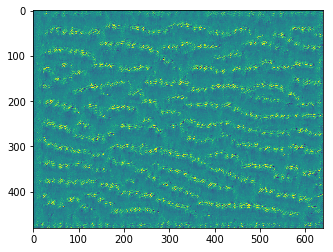

In [88]:
layer_dict = dict([(layer.name, layer) for layer in model.layers]) #for j in layer_dict.keys():
filter_index = 60
layer_name = 'conv2d_8'
# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
loss = K.mean(layer_output[:, :, :, filter_index])

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, model.input)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([model.input], [loss, grads])


# we start from a gray image with some noise
input_img_data = np.random.random((1, 480, 640, 1)) * 20 + 128.
# run gradient ascent for 20 steps
for i in range(100):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value*1
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1ampling2d_1'
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

img = input_img_data[0]
img = deprocess_image(img)
plt.figure()
plt.imshow(img[:,:,0])

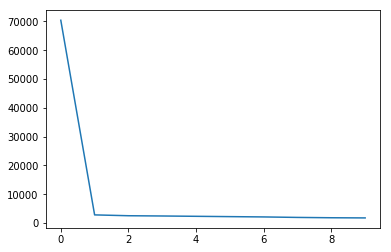

In [89]:
plt.figure()
plt.plot(np.linalg.svd(img[:,:,0])[1][:10])

In [78]:
model = network(inputs)

NameError: name 'network' is not defined

In [24]:
batch_size = 8

In [23]:
model_checkpoint = ModelCheckpoint('2017-06-16-30_res_depth_normal_batch4.hdf5', monitor='loss',verbose=1, save_best_only=True)
check2 = TensorBoard(log_dir='logs_new', histogram_freq=0, batch_size=batch_size, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
print('Fitting model...')
model.fit_generator(train, nb_epoch=1000,steps_per_epoch=100, verbose=1, shuffle=True, callbacks=[model_checkpoint,check2])from keras import backend as K
class Image_Saver(Callback):
    def on_train_begin(self,logs={}):
        self.var_y_pred = tf.placeholder(tf.float32, [FLAGS.batch_size, 480,640,1])
        #self.var_y_pred = tf.Variable(0., validate_shape=False)

    def on_batch_end(self, batch, logs={}):
            #callback = TensorBoard(log_path)
            #callback.set_model(model)
            
            print type(K.eval(self.model.outputs[0]))
            x=self.model.predict_on_batch(batch)
            writer = tf.summary.FileWriter('./logs1')
            writer.add_summary(tf.summary.image('input', x[0]))
save = Image_Saver()

In [15]:
batch_size=4

In [16]:
model_checkpoint = ModelCheckpoint('2017-06-16-30_res_depth_normal_batch4.hdf5', monitor='loss',verbose=1, save_best_only=True)
check2 = TensorBoard(log_dir='logs_new', histogram_freq=0, batch_size=batch_size, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
print('Fitting model...')
model.fit_generator(train, nb_epoch=1000,steps_per_epoch=100, verbose=1, shuffle=True, callbacks=[model_checkpoint,check2])

Fitting model...


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., shuffle=True, verbose=1, steps_per_epoch=100, epochs=1000, callbacks=[<keras.ca...)`
  after removing the cwd from sys.path.


Epoch 1/1000


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


 99/100 [============================>.] - ETA: 0s - loss: 0.5857 - acc: 0.8253
Epoch 00001: loss improved from inf to 0.58565, saving model to 2017-06-16-30_res_depth_normal_batch4.hdf5
100/100 [==============================] - 55s 554ms/step - loss: 0.5856 - acc: 0.8253
Epoch 2/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.5720 - acc: 0.8252
Epoch 00002: loss improved from 0.58565 to 0.57194, saving model to 2017-06-16-30_res_depth_normal_batch4.hdf5
100/100 [==============================] - 45s 448ms/step - loss: 0.5719 - acc: 0.8253
Epoch 3/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.5482 - acc: 0.8258
Epoch 00003: loss improved from 0.57194 to 0.54776, saving model to 2017-06-16-30_res_depth_normal_batch4.hdf5
100/100 [==============================] - 44s 439ms/step - loss: 0.5478 - acc: 0.8258
Epoch 4/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1704 - acc: 0.8257
Epoch 00004: loss improved from 0.54776 to 0.16946,

Epoch 31/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0520 - acc: 0.8256
Epoch 00031: loss improved from 0.05215 to 0.05203, saving model to 2017-06-16-30_res_depth_normal_batch4.hdf5
100/100 [==============================] - 30s 303ms/step - loss: 0.0520 - acc: 0.8255
Epoch 32/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0523 - acc: 0.8253
Epoch 00032: loss did not improve
100/100 [==============================] - 30s 302ms/step - loss: 0.0522 - acc: 0.8253
Epoch 33/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0517 - acc: 0.8260
Epoch 00033: loss improved from 0.05203 to 0.05161, saving model to 2017-06-16-30_res_depth_normal_batch4.hdf5
100/100 [==============================] - 30s 303ms/step - loss: 0.0516 - acc: 0.8261
Epoch 34/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0514 - acc: 0.8258
Epoch 00034: loss improved from 0.05161 to 0.05137, saving model to 2017-06-16-30_res_depth_normal_batch4.h

Epoch 64/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0466 - acc: 0.9369
Epoch 00064: loss improved from 0.04684 to 0.04664, saving model to 2017-06-16-30_res_depth_normal_batch4.hdf5
100/100 [==============================] - 30s 302ms/step - loss: 0.0466 - acc: 0.9368
Epoch 65/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0470 - acc: 0.9361
Epoch 00065: loss did not improve
100/100 [==============================] - 30s 302ms/step - loss: 0.0470 - acc: 0.9362
Epoch 66/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0456 - acc: 0.9377
Epoch 00066: loss improved from 0.04664 to 0.04564, saving model to 2017-06-16-30_res_depth_normal_batch4.hdf5
100/100 [==============================] - 30s 303ms/step - loss: 0.0456 - acc: 0.9377
Epoch 67/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0467 - acc: 0.9363
Epoch 00067: loss did not improve
100/100 [==============================] - 30s 301ms/step - loss: 0.0467 

Epoch 99/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0426 - acc: 0.9402
Epoch 00099: loss did not improve
100/100 [==============================] - 30s 301ms/step - loss: 0.0426 - acc: 0.9402
Epoch 100/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0425 - acc: 0.9408
Epoch 00100: loss improved from 0.04259 to 0.04247, saving model to 2017-06-16-30_res_depth_normal_batch4.hdf5
100/100 [==============================] - 30s 302ms/step - loss: 0.0425 - acc: 0.9408
Epoch 101/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0420 - acc: 0.9413
Epoch 00101: loss improved from 0.04247 to 0.04198, saving model to 2017-06-16-30_res_depth_normal_batch4.hdf5
100/100 [==============================] - 30s 302ms/step - loss: 0.0420 - acc: 0.9413
Epoch 102/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0420 - acc: 0.9415
Epoch 00102: loss improved from 0.04198 to 0.04195, saving model to 2017-06-16-30_res_depth_normal_batch

Epoch 132/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0399 - acc: 0.9424
Epoch 00132: loss did not improve
100/100 [==============================] - 30s 301ms/step - loss: 0.0399 - acc: 0.9424
Epoch 133/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0388 - acc: 0.9437
Epoch 00133: loss improved from 0.03905 to 0.03881, saving model to 2017-06-16-30_res_depth_normal_batch4.hdf5
100/100 [==============================] - 30s 301ms/step - loss: 0.0388 - acc: 0.9437
Epoch 134/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0389 - acc: 0.9435
Epoch 00134: loss did not improve
100/100 [==============================] - 30s 301ms/step - loss: 0.0390 - acc: 0.9435
Epoch 135/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0390 - acc: 0.9433
Epoch 00135: loss did not improve
100/100 [==============================] - 30s 301ms/step - loss: 0.0391 - acc: 0.9433
Epoch 136/1000
 99/100 [============================>.] - E

 99/100 [============================>.] - ETA: 0s - loss: 0.0368 - acc: 0.9456
Epoch 00166: loss did not improve
100/100 [==============================] - 30s 301ms/step - loss: 0.0368 - acc: 0.9456
Epoch 167/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0371 - acc: 0.9441
Epoch 00167: loss did not improve
100/100 [==============================] - 30s 301ms/step - loss: 0.0371 - acc: 0.9441
Epoch 168/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0363 - acc: 0.9459
Epoch 00168: loss improved from 0.03636 to 0.03631, saving model to 2017-06-16-30_res_depth_normal_batch4.hdf5
100/100 [==============================] - 30s 302ms/step - loss: 0.0363 - acc: 0.9459
Epoch 169/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0364 - acc: 0.9458
Epoch 00169: loss did not improve
100/100 [==============================] - 30s 301ms/step - loss: 0.0364 - acc: 0.9458
Epoch 170/1000
 99/100 [============================>.] - ETA: 0s - loss: 

 99/100 [============================>.] - ETA: 0s - loss: 0.0346 - acc: 0.9473
Epoch 00199: loss did not improve
100/100 [==============================] - 30s 301ms/step - loss: 0.0345 - acc: 0.9474
Epoch 200/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0354 - acc: 0.9459
Epoch 00200: loss did not improve
100/100 [==============================] - 30s 301ms/step - loss: 0.0354 - acc: 0.9459
Epoch 201/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0339 - acc: 0.9479
Epoch 00201: loss did not improve
100/100 [==============================] - 30s 301ms/step - loss: 0.0339 - acc: 0.9478
Epoch 202/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0346 - acc: 0.9468
Epoch 00202: loss did not improve
100/100 [==============================] - 30s 302ms/step - loss: 0.0345 - acc: 0.9469
Epoch 203/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0339 - acc: 0.9481
Epoch 00203: loss did not improve
100/100 [=============

Epoch 235/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0330 - acc: 0.9485
Epoch 00235: loss did not improve
100/100 [==============================] - 30s 301ms/step - loss: 0.0330 - acc: 0.9485
Epoch 236/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0314 - acc: 0.9510
Epoch 00236: loss improved from 0.03213 to 0.03142, saving model to 2017-06-16-30_res_depth_normal_batch4.hdf5
100/100 [==============================] - 30s 301ms/step - loss: 0.0314 - acc: 0.9510
Epoch 237/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0323 - acc: 0.9499
Epoch 00237: loss did not improve
100/100 [==============================] - 30s 300ms/step - loss: 0.0323 - acc: 0.9498
Epoch 238/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0322 - acc: 0.9499
Epoch 00238: loss did not improve
100/100 [==============================] - 30s 301ms/step - loss: 0.0322 - acc: 0.9499
Epoch 239/1000
 99/100 [============================>.] - E

Epoch 271/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0306 - acc: 0.9518
Epoch 00271: loss did not improve
100/100 [==============================] - 30s 301ms/step - loss: 0.0306 - acc: 0.9518
Epoch 272/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0309 - acc: 0.9512
Epoch 00272: loss did not improve
100/100 [==============================] - 30s 300ms/step - loss: 0.0309 - acc: 0.9512
Epoch 273/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0303 - acc: 0.9521
Epoch 00273: loss did not improve
100/100 [==============================] - 30s 301ms/step - loss: 0.0303 - acc: 0.9521
Epoch 274/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0305 - acc: 0.9516
Epoch 00274: loss did not improve
100/100 [==============================] - 30s 300ms/step - loss: 0.0306 - acc: 0.9515
Epoch 275/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0307 - acc: 0.9515
Epoch 00275: loss did not improve
100/100

Epoch 308/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0292 - acc: 0.9532
Epoch 00308: loss did not improve
100/100 [==============================] - 30s 300ms/step - loss: 0.0292 - acc: 0.9532
Epoch 309/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0298 - acc: 0.9521
Epoch 00309: loss did not improve
100/100 [==============================] - 30s 300ms/step - loss: 0.0298 - acc: 0.9521
Epoch 310/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0296 - acc: 0.9524
Epoch 00310: loss did not improve
100/100 [==============================] - 30s 300ms/step - loss: 0.0296 - acc: 0.9525
Epoch 311/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0291 - acc: 0.9532
Epoch 00311: loss did not improve
100/100 [==============================] - 30s 300ms/step - loss: 0.0291 - acc: 0.9532
Epoch 312/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0292 - acc: 0.9530
Epoch 00312: loss did not improve
100/100

Epoch 344/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0291 - acc: 0.9528
Epoch 00344: loss did not improve
100/100 [==============================] - 30s 300ms/step - loss: 0.0291 - acc: 0.9528
Epoch 345/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0289 - acc: 0.9529
Epoch 00345: loss did not improve
100/100 [==============================] - 30s 301ms/step - loss: 0.0289 - acc: 0.9529
Epoch 346/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0276 - acc: 0.9552
Epoch 00346: loss improved from 0.02792 to 0.02760, saving model to 2017-06-16-30_res_depth_normal_batch4.hdf5
100/100 [==============================] - 30s 302ms/step - loss: 0.0276 - acc: 0.9552
Epoch 347/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0286 - acc: 0.9537
Epoch 00347: loss did not improve
100/100 [==============================] - 30s 300ms/step - loss: 0.0286 - acc: 0.9536
Epoch 348/1000
 99/100 [============================>.] - E

Epoch 380/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0277 - acc: 0.9546
Epoch 00380: loss did not improve
100/100 [==============================] - 30s 300ms/step - loss: 0.0276 - acc: 0.9546
Epoch 381/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0275 - acc: 0.9548
Epoch 00381: loss did not improve
100/100 [==============================] - 30s 300ms/step - loss: 0.0275 - acc: 0.9548
Epoch 382/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0277 - acc: 0.9545
Epoch 00382: loss did not improve
100/100 [==============================] - 30s 300ms/step - loss: 0.0277 - acc: 0.9546
Epoch 383/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0272 - acc: 0.9554
Epoch 00383: loss did not improve
100/100 [==============================] - 30s 300ms/step - loss: 0.0272 - acc: 0.9554
Epoch 384/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0275 - acc: 0.9549
Epoch 00384: loss did not improve
100/100

Epoch 417/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0268 - acc: 0.9557
Epoch 00417: loss did not improve
100/100 [==============================] - 30s 299ms/step - loss: 0.0268 - acc: 0.9557
Epoch 418/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0269 - acc: 0.9556
Epoch 00418: loss did not improve
100/100 [==============================] - 30s 300ms/step - loss: 0.0268 - acc: 0.9556
Epoch 419/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0268 - acc: 0.9555
Epoch 00419: loss did not improve
100/100 [==============================] - 30s 300ms/step - loss: 0.0268 - acc: 0.9554
Epoch 420/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0266 - acc: 0.9559
Epoch 00420: loss did not improve
100/100 [==============================] - 30s 300ms/step - loss: 0.0266 - acc: 0.9559
Epoch 421/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0268 - acc: 0.9556
Epoch 00421: loss did not improve
100/100

 99/100 [============================>.] - ETA: 0s - loss: 0.0258 - acc: 0.9569
Epoch 00453: loss did not improve
100/100 [==============================] - 30s 299ms/step - loss: 0.0259 - acc: 0.9569
Epoch 454/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0266 - acc: 0.9556
Epoch 00454: loss did not improve
100/100 [==============================] - 30s 300ms/step - loss: 0.0266 - acc: 0.9556
Epoch 455/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0254 - acc: 0.9578
Epoch 00455: loss improved from 0.02555 to 0.02536, saving model to 2017-06-16-30_res_depth_normal_batch4.hdf5
100/100 [==============================] - 30s 300ms/step - loss: 0.0254 - acc: 0.9577
Epoch 456/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0256 - acc: 0.9575
Epoch 00456: loss did not improve
100/100 [==============================] - 30s 300ms/step - loss: 0.0256 - acc: 0.9576
Epoch 457/1000
 99/100 [============================>.] - ETA: 0s - loss: 

Epoch 490/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0259 - acc: 0.9566
Epoch 00490: loss did not improve
100/100 [==============================] - 30s 299ms/step - loss: 0.0259 - acc: 0.9566
Epoch 491/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0249 - acc: 0.9584
Epoch 00491: loss improved from 0.02519 to 0.02493, saving model to 2017-06-16-30_res_depth_normal_batch4.hdf5
100/100 [==============================] - 30s 299ms/step - loss: 0.0249 - acc: 0.9583
Epoch 492/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0256 - acc: 0.9570
Epoch 00492: loss did not improve
100/100 [==============================] - 30s 299ms/step - loss: 0.0256 - acc: 0.9570
Epoch 493/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0251 - acc: 0.9580
Epoch 00493: loss did not improve
100/100 [==============================] - 30s 300ms/step - loss: 0.0251 - acc: 0.9580
Epoch 494/1000
 99/100 [============================>.] - E

Epoch 527/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0249 - acc: 0.9579
Epoch 00527: loss did not improve
100/100 [==============================] - 30s 299ms/step - loss: 0.0249 - acc: 0.9579
Epoch 528/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0252 - acc: 0.9576
Epoch 00528: loss did not improve
100/100 [==============================] - 30s 299ms/step - loss: 0.0251 - acc: 0.9576
Epoch 529/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0253 - acc: 0.9575
Epoch 00529: loss did not improve
100/100 [==============================] - 30s 299ms/step - loss: 0.0253 - acc: 0.9576
Epoch 530/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0244 - acc: 0.9589
Epoch 00530: loss improved from 0.02452 to 0.02439, saving model to 2017-06-16-30_res_depth_normal_batch4.hdf5
100/100 [==============================] - 30s 300ms/step - loss: 0.0244 - acc: 0.9588
Epoch 531/1000
 99/100 [============================>.] - E

 99/100 [============================>.] - ETA: 0s - loss: 0.0242 - acc: 0.9588
Epoch 00563: loss did not improve
100/100 [==============================] - 30s 299ms/step - loss: 0.0243 - acc: 0.9588
Epoch 564/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0254 - acc: 0.9572
Epoch 00564: loss did not improve
100/100 [==============================] - 30s 298ms/step - loss: 0.0255 - acc: 0.9572
Epoch 565/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0247 - acc: 0.9581
Epoch 00565: loss did not improve
100/100 [==============================] - 30s 299ms/step - loss: 0.0246 - acc: 0.9581
Epoch 566/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0241 - acc: 0.9593
Epoch 00566: loss improved from 0.02416 to 0.02408, saving model to 2017-06-16-30_res_depth_normal_batch4.hdf5
100/100 [==============================] - 30s 299ms/step - loss: 0.0241 - acc: 0.9593
Epoch 567/1000
 99/100 [============================>.] - ETA: 0s - loss: 

Epoch 599/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0247 - acc: 0.9580
Epoch 00599: loss did not improve
100/100 [==============================] - 30s 299ms/step - loss: 0.0247 - acc: 0.9580
Epoch 600/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0243 - acc: 0.9585
Epoch 00600: loss did not improve
100/100 [==============================] - 30s 298ms/step - loss: 0.0243 - acc: 0.9585
Epoch 601/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0240 - acc: 0.9592
Epoch 00601: loss did not improve
100/100 [==============================] - 30s 298ms/step - loss: 0.0240 - acc: 0.9593
Epoch 602/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0247 - acc: 0.9580
Epoch 00602: loss did not improve
100/100 [==============================] - 30s 299ms/step - loss: 0.0247 - acc: 0.9580
Epoch 603/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0236 - acc: 0.9599
Epoch 00603: loss improved from 0.02374 t

Epoch 636/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0235 - acc: 0.9600
Epoch 00636: loss did not improve
100/100 [==============================] - 30s 297ms/step - loss: 0.0235 - acc: 0.9600
Epoch 637/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0246 - acc: 0.9581
Epoch 00637: loss did not improve
100/100 [==============================] - 30s 299ms/step - loss: 0.0246 - acc: 0.9581
Epoch 638/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0231 - acc: 0.9605
Epoch 00638: loss improved from 0.02339 to 0.02314, saving model to 2017-06-16-30_res_depth_normal_batch4.hdf5
100/100 [==============================] - 30s 299ms/step - loss: 0.0231 - acc: 0.9604
Epoch 639/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0239 - acc: 0.9593
Epoch 00639: loss did not improve
100/100 [==============================] - 30s 297ms/step - loss: 0.0239 - acc: 0.9592
Epoch 640/1000
 99/100 [============================>.] - E

 99/100 [============================>.] - ETA: 0s - loss: 0.0233 - acc: 0.9599
Epoch 00673: loss did not improve
100/100 [==============================] - 30s 298ms/step - loss: 0.0233 - acc: 0.9599
Epoch 674/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0238 - acc: 0.9593
Epoch 00674: loss did not improve
100/100 [==============================] - 30s 298ms/step - loss: 0.0238 - acc: 0.9592
Epoch 675/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0234 - acc: 0.9600
Epoch 00675: loss did not improve
100/100 [==============================] - 30s 298ms/step - loss: 0.0234 - acc: 0.9600
Epoch 676/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0231 - acc: 0.9607
Epoch 00676: loss did not improve
100/100 [==============================] - 30s 297ms/step - loss: 0.0231 - acc: 0.9607
Epoch 677/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0235 - acc: 0.9595
Epoch 00677: loss did not improve
100/100 [=============

Epoch 710/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0229 - acc: 0.9606
Epoch 00710: loss did not improve
100/100 [==============================] - 30s 298ms/step - loss: 0.0229 - acc: 0.9606
Epoch 711/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0230 - acc: 0.9605
Epoch 00711: loss did not improve
100/100 [==============================] - 30s 297ms/step - loss: 0.0230 - acc: 0.9605
Epoch 712/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0232 - acc: 0.9602
Epoch 00712: loss did not improve
100/100 [==============================] - 30s 297ms/step - loss: 0.0231 - acc: 0.9603
Epoch 713/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0231 - acc: 0.9601
Epoch 00713: loss did not improve
100/100 [==============================] - 30s 297ms/step - loss: 0.0231 - acc: 0.9601
Epoch 714/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0235 - acc: 0.9597
Epoch 00714: loss did not improve
100/100

Epoch 747/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0230 - acc: 0.9602
Epoch 00747: loss did not improve
100/100 [==============================] - 30s 298ms/step - loss: 0.0230 - acc: 0.9602
Epoch 748/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0228 - acc: 0.9606
Epoch 00748: loss did not improve
100/100 [==============================] - 30s 297ms/step - loss: 0.0228 - acc: 0.9606
Epoch 749/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0233 - acc: 0.9597
Epoch 00749: loss did not improve
100/100 [==============================] - 30s 297ms/step - loss: 0.0234 - acc: 0.9596
Epoch 750/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0227 - acc: 0.9606
Epoch 00750: loss did not improve
100/100 [==============================] - 30s 298ms/step - loss: 0.0227 - acc: 0.9606
Epoch 751/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0225 - acc: 0.9612
Epoch 00751: loss improved from 0.02262 t

Epoch 784/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0228 - acc: 0.9606
Epoch 00784: loss did not improve
100/100 [==============================] - 30s 298ms/step - loss: 0.0228 - acc: 0.9606
Epoch 785/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0226 - acc: 0.9609
Epoch 00785: loss did not improve
100/100 [==============================] - 30s 297ms/step - loss: 0.0226 - acc: 0.9609
Epoch 786/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0224 - acc: 0.9613
Epoch 00786: loss improved from 0.02238 to 0.02235, saving model to 2017-06-16-30_res_depth_normal_batch4.hdf5
100/100 [==============================] - 30s 297ms/step - loss: 0.0224 - acc: 0.9613
Epoch 787/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0227 - acc: 0.9608
Epoch 00787: loss did not improve
100/100 [==============================] - 30s 296ms/step - loss: 0.0227 - acc: 0.9608
Epoch 788/1000
 99/100 [============================>.] - E

Epoch 821/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0220 - acc: 0.9618
Epoch 00821: loss improved from 0.02221 to 0.02202, saving model to 2017-06-16-30_res_depth_normal_batch4.hdf5
100/100 [==============================] - 30s 297ms/step - loss: 0.0220 - acc: 0.9618
Epoch 822/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0228 - acc: 0.9606
Epoch 00822: loss did not improve
100/100 [==============================] - 30s 297ms/step - loss: 0.0228 - acc: 0.9607
Epoch 823/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0228 - acc: 0.9604
Epoch 00823: loss did not improve
100/100 [==============================] - 30s 297ms/step - loss: 0.0228 - acc: 0.9604
Epoch 824/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0231 - acc: 0.9599
Epoch 00824: loss did not improve
100/100 [==============================] - 30s 297ms/step - loss: 0.0231 - acc: 0.9599
Epoch 825/1000
 99/100 [============================>.] - E

Epoch 858/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0220 - acc: 0.9616
Epoch 00858: loss did not improve
100/100 [==============================] - 30s 297ms/step - loss: 0.0220 - acc: 0.9616
Epoch 859/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0228 - acc: 0.9605
Epoch 00859: loss did not improve
100/100 [==============================] - 30s 297ms/step - loss: 0.0228 - acc: 0.9606
Epoch 860/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0222 - acc: 0.9613
Epoch 00860: loss did not improve
100/100 [==============================] - 30s 297ms/step - loss: 0.0222 - acc: 0.9614
Epoch 861/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0221 - acc: 0.9616
Epoch 00861: loss did not improve
100/100 [==============================] - 30s 296ms/step - loss: 0.0221 - acc: 0.9616
Epoch 862/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0224 - acc: 0.9611
Epoch 00862: loss did not improve
100/100

 99/100 [============================>.] - ETA: 0s - loss: 0.0220 - acc: 0.9616
Epoch 00895: loss did not improve
100/100 [==============================] - 30s 297ms/step - loss: 0.0220 - acc: 0.9616
Epoch 896/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0217 - acc: 0.9621
Epoch 00896: loss did not improve
100/100 [==============================] - 30s 296ms/step - loss: 0.0217 - acc: 0.9621
Epoch 897/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0223 - acc: 0.9612
Epoch 00897: loss did not improve
100/100 [==============================] - 30s 296ms/step - loss: 0.0223 - acc: 0.9612
Epoch 898/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0216 - acc: 0.9621
Epoch 00898: loss did not improve
100/100 [==============================] - 30s 297ms/step - loss: 0.0217 - acc: 0.9620
Epoch 899/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0222 - acc: 0.9613
Epoch 00899: loss did not improve
100/100 [=============

Epoch 932/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0228 - acc: 0.9604
Epoch 00932: loss did not improve
100/100 [==============================] - 30s 297ms/step - loss: 0.0228 - acc: 0.9605
Epoch 933/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0217 - acc: 0.9620
Epoch 00933: loss did not improve
100/100 [==============================] - 30s 296ms/step - loss: 0.0217 - acc: 0.9620
Epoch 934/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0221 - acc: 0.9614
Epoch 00934: loss did not improve
100/100 [==============================] - 30s 297ms/step - loss: 0.0221 - acc: 0.9614
Epoch 935/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0221 - acc: 0.9614
Epoch 00935: loss did not improve
100/100 [==============================] - 30s 296ms/step - loss: 0.0220 - acc: 0.9614
Epoch 936/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0214 - acc: 0.9626
Epoch 00936: loss improved from 0.02147 t

 99/100 [============================>.] - ETA: 0s - loss: 0.0220 - acc: 0.9615
Epoch 00969: loss did not improve
100/100 [==============================] - 30s 296ms/step - loss: 0.0220 - acc: 0.9615
Epoch 970/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0223 - acc: 0.9611
Epoch 00970: loss did not improve
100/100 [==============================] - 30s 296ms/step - loss: 0.0224 - acc: 0.9610
Epoch 971/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0216 - acc: 0.9622
Epoch 00971: loss did not improve
100/100 [==============================] - 30s 296ms/step - loss: 0.0216 - acc: 0.9622
Epoch 972/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0217 - acc: 0.9622
Epoch 00972: loss did not improve
100/100 [==============================] - 29s 295ms/step - loss: 0.0217 - acc: 0.9621
Epoch 973/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0214 - acc: 0.9624
Epoch 00973: loss improved from 0.02141 to 0.02138, savi

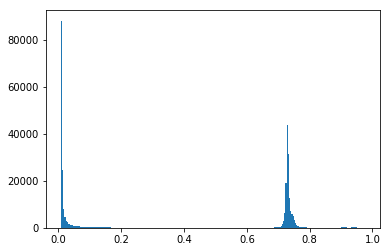

In [198]:
plt.figure()
plt.hist(img.ravel(), bins=256)
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


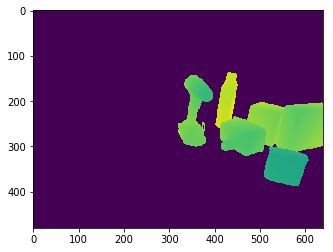

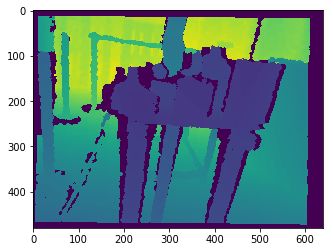

In [215]:
path = "/media/drc/DATA/chris_labelfusion/CORL2017/object_database/"
d_dir = os.listdir(path+"depth/")
gt_dir = os.listdir(path+"gtdepth/")
choice = np.random.randint(len(d_dir))
g= misc.imread(path+"gtdepth/"+gt_dir[choice])
d= misc.imread(path+"depth/"+d_dir[choice])
plt.imshow(g)
plt.figure()
plt.imshow(d)

In [142]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

NameError: name 'y_test' is not defined

In [69]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve

In [70]:
def test_on_set1(test,size=1000):
    def crop1(x,x1 = 200,x2 = 500,y1 = 200, y2 = 450):
        x = x[y1:y2,x1:x2]
        return x
    data = np.zeros((1,480,640,2))
    pred = []
    targ = []
    prob = []
    for i in test[:size]:
        r = normalize(misc.imread(i[0]))
        data[0,:,:,0] = r
        normal_img = grab_frame1(i[1],convert_rgb_normal)[:,:,2]
        d = crop1(hot_vectorize(misc.imread(i[2])))
        p = 1-normal_img
        p = crop1(p).flatten()
        prob.extend(p)
        pred.extend(list((np.round(p).astype(int))))
        targ.extend(list(d.flatten().astype(int)))
    return targ,prob

In [71]:
def test_on_set2(test,model,size=1000):
    data = np.zeros((1,480,640,1))
    pred = []
    targ = []
    prob = []
    for i in test[:size]:
        r = misc.imread(i[0])/3500.
        data[0,:,:,0] = r
        d = crop(hot_vectorize(misc.imread(i[2])))
        p = model.predict_on_batch(data)
        p = crop(p[0,:,:,0]).flatten()
        prob.extend(p)
        pred.extend(list((np.round(p).astype(int))))
        targ.extend(list(d.flatten().astype(int)))
    return targ,prob

In [72]:
from scipy import misc

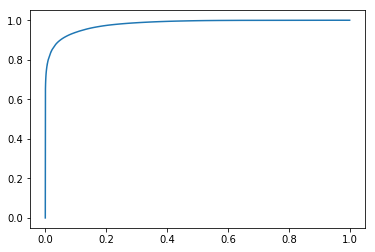

In [27]:
a=roc_curve(y_true,y_pred)
plt.figure()
plt.plot(a[0],a[1])
plt.show()

In [30]:
def test_on_set(test,model,size=1000):
    data = np.zeros((1,480,640,2))
    pred = []
    targ = []
    prob = []
    for i in test[:size]:
        r = normalize(misc.imread(i[0]))
        data[0,:,:,0] = r
        normal_img = grab_frame1(i[1],convert_rgb_normal)[:,:,2]
        data[0,:,:,1] = normal_img
        d = crop(hot_vectorize(misc.imread(i[2])))
        p = model.predict_on_batch(data)
        p = crop(p[0,:,:,0]).flatten()
        prob.extend(p)
        pred.extend(list((np.round(p).astype(int))))
        targ.extend(list(d.flatten().astype(int)))
    return targ,prob


In [45]:
targ3,prob3 = test_on_set1(test,size=100)
roc3 = roc_curve(targ3,prob3)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]


In [40]:
targ1,prob1 = test_on_set2(test,model,size=100)
roc1 = roc_curve(targ1,prob1)

targ2,prob2 = test_on_set2(test,autoencoder,size=100)
roc2 = roc_curve(targ2,prob2)



/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


In [18]:
test = generate_data_custom_depth(test,img_height=480,img_width=640)

In [117]:
val = cross_validate(samples,10)
train, test = grab_test_train(val,1)

In [17]:
test

array([['/media/drc/DATA/chris_labelfusion/RGBDCNN/2017-05-25-15/0000001364_2017-05-25-15_depth_ground_truth.png',
        '/media/drc/DATA/chris_labelfusion/RGBDCNN/2017-05-25-15/0000001364_2017-05-25-15_normal_ground_truth.png',
        '/media/drc/DATA/chris_labelfusion/RGBDCNN/2017-05-25-15/0000001364_depth.png'],
       ['/media/drc/DATA/chris_labelfusion/RGBDCNN/2017-06-14-56/0000000956_2017-06-14-56_depth_ground_truth.png',
        '/media/drc/DATA/chris_labelfusion/RGBDCNN/2017-06-14-56/0000000956_2017-06-14-56_normal_ground_truth.png',
        '/media/drc/DATA/chris_labelfusion/RGBDCNN/2017-06-14-56/0000000956_depth.png'],
       ['/media/drc/DATA/chris_labelfusion/RGBDCNN/2017-06-16-18/0000002090_2017-06-16-18_depth_ground_truth.png',
        '/media/drc/DATA/chris_labelfusion/RGBDCNN/2017-06-16-18/0000002090_2017-06-16-18_normal_ground_truth.png',
        '/media/drc/DATA/chris_labelfusion/RGBDCNN/2017-06-16-18/0000002090_depth.png'],
       ...,
       ['/media/drc/DATA/chr

In [23]:
a=model.predict_generator(test,steps = 100)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


# one scene model

In [126]:
roc=[]
curve = []
acc = []
#cross validate but sample from each slice 
for i in range(1,10):
    train, test = grab_test_train(val,i)
    y_true=[]
    y_pred=[]
    for j in range(1000,1050):
        imd = misc.imread(test[j][0])/3500.
        iml = hot_vectorize(misc.imread(test[j][2]))
        pred = model.predict_on_batch(np.reshape(imd,(1,480,640,1)))[0,:,:,0]
        y_pred.extend(crop(pred).flatten().tolist())
        y_true.extend(crop(iml).flatten().tolist())
    roc.append(roc_auc_score(y_true, y_pred))
    acc.append(np.mean(np.round(y_pred) ==y_true))
    curve.append(roc_curve(y_true,y_pred))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()


In [127]:
print np.mean(roc)

0.8637410047752676


In [128]:
print np.mean(acc)

0.9394653055362213


In [137]:
len(curve)

9

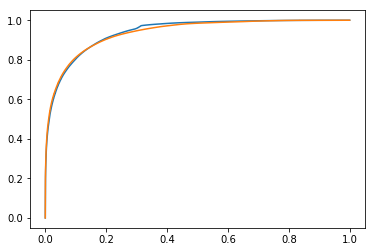

In [131]:
plt.figure()
for i in curve:
    plt.plot(i[0],i[1])
plt.show()

In [132]:
roc=[]
curve = []
acc = []
#cross validate but sample from each slice 
for i in range(1,10):
    train, test = grab_test_train(val,i)
    y_true=[]
    y_pred=[]
    for j in range(1000,1050):
        imd = misc.imread(test[j][0])/3500.
        iml = hot_vectorize(misc.imread(test[j][2]))
        pred = model1.predict_on_batch(np.reshape(imd,(1,480,640,1)))[0,:,:,0]
        y_pred.extend(crop(pred).flatten().tolist())
        y_true.extend(crop(iml).flatten().tolist())
    roc.append(roc_auc_score(y_true, y_pred))
    acc.append(np.mean(np.round(y_pred) ==y_true))
    curve.append(roc_curve(y_true,y_pred))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()


In [133]:
print np.mean(roc)

0.955896244216099


In [134]:
print np.mean(acc)

0.956124667174881


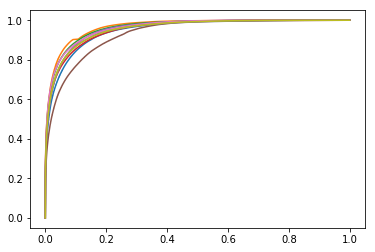

In [135]:
plt.figure()
for i in curve:
    plt.plot(i[0],i[1])
plt.show()

In [ ]:
plt.figure()
plt.title("ROC curve for NDP prediction")

plt.plot(roc1[0],roc1[1],label= "Residual")
plt.plot(roc2[0],roc2[1],label= "Encoder-Decoder")
plt.plot(roc3[0],roc3[1],label= "Simple Normal Threshold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.show()

In [ ]:
from pandas_ml import ConfusionMatrix
plt.figure()
c = ConfusionMatrix(targ,pred)
c.plot(normalized=True)
print (f1_score(targ,pred),roc)

In [81]:
test_on_set(test,autoencoder)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


AttributeError: 'numpy.ndarray' object has no attribute 'read'

In [55]:
%matplotlib inline
gt = g/3000.
pred = model.predict_on_batch(np.reshape(gt,(1,480,640,1)))
plt.imshow(np.reshape(pred,(480,640)))

NameError: name 'g' is not defined

In [26]:
num = 1

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


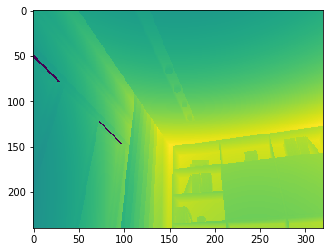

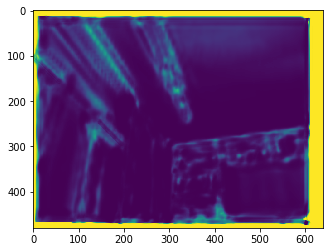

In [139]:
path  = "/media/drc/DATA/train/0/"+str(75)+"/depth/"
img_path = path+os.listdir(path)[num]
num+=1
im = misc.imread(img_path)
%matplotlib inline
plt.figure()
plt.imshow(im)
plt.figure()
im = misc.imresize(im,(480,640))/255.
pred = model.predict_on_batch(np.reshape(im,(1,480,640,1)))
plt.imshow(np.reshape(pred,(480,640)))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


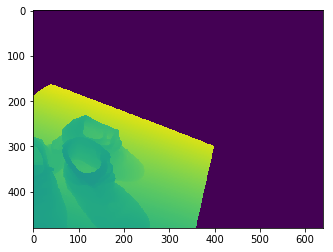

In [59]:
path  = "/media/drc/DATA/chris_labelfusion/processed/rendered_images/000394_depth.png"
im = misc.imread(path)
plt.figure()
plt.imshow(im)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


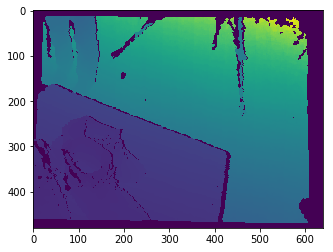

In [60]:
path  = "/media/drc/DATA/chris_labelfusion/processed/images/000394_depth.png"
im1 = misc.imread(path)
plt.figure()
plt.imshow(im1)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


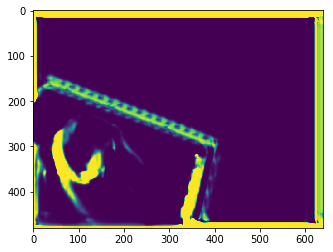

In [63]:
plt.figure()
im = misc.imresize(im,(480,640))/1000.
pred = model.predict_on_batch(np.reshape(im,(1,480,640,1)))
plt.imshow(np.reshape(pred,(480,640)))

In [105]:
test = train.next()
X_Test = test[0][0:1,:,:,0:1]

Y_Test = test[1][0:1]
imgs_mask_test = model.predict_on_batch(X_Test)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


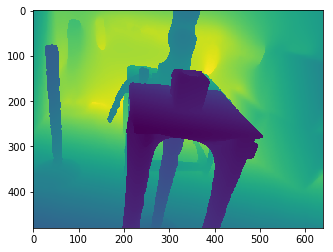

In [106]:
%matplotlib inline
img = X_Test[0][:,:,0]
plt.imshow(img)

In [86]:
i=np.reshape(img,(1,480,640,1))

In [89]:
%%timeit
a=model.predict_on_batch(i)

100 loops, best of 3: 13.4 ms per loop


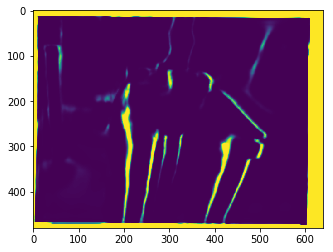

In [107]:
%matplotlib inline

pred = model.predict_on_batch(np.reshape(img,(1,480,640,1)))
plt.imshow(np.reshape(pred,(480,640)))

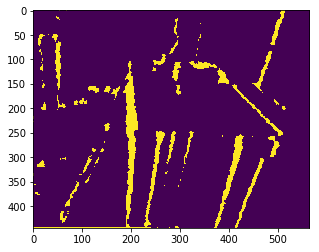

In [112]:
%matplotlib inline
img1 = np.reshape(Y_Test[0],(480,640))
plt.imshow(crop(img1))

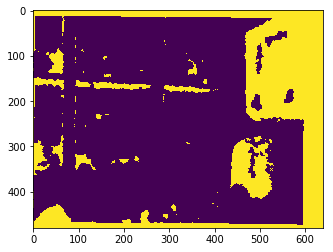

In [94]:
plt.imshow(img1)

In [111]:
def crop(x,y1 = 25,y2 = 470,x1 = 10, x2 = 575):
    return x[y1:y2,x1:x2]

In [ ]:
img1 = np.copy(img)
img1[img1>.3] =1
plt.imshow(img1)